In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

2024-01-03 00:12:15.422597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 00:12:15.422639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 00:12:15.422674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 00:12:15.430609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


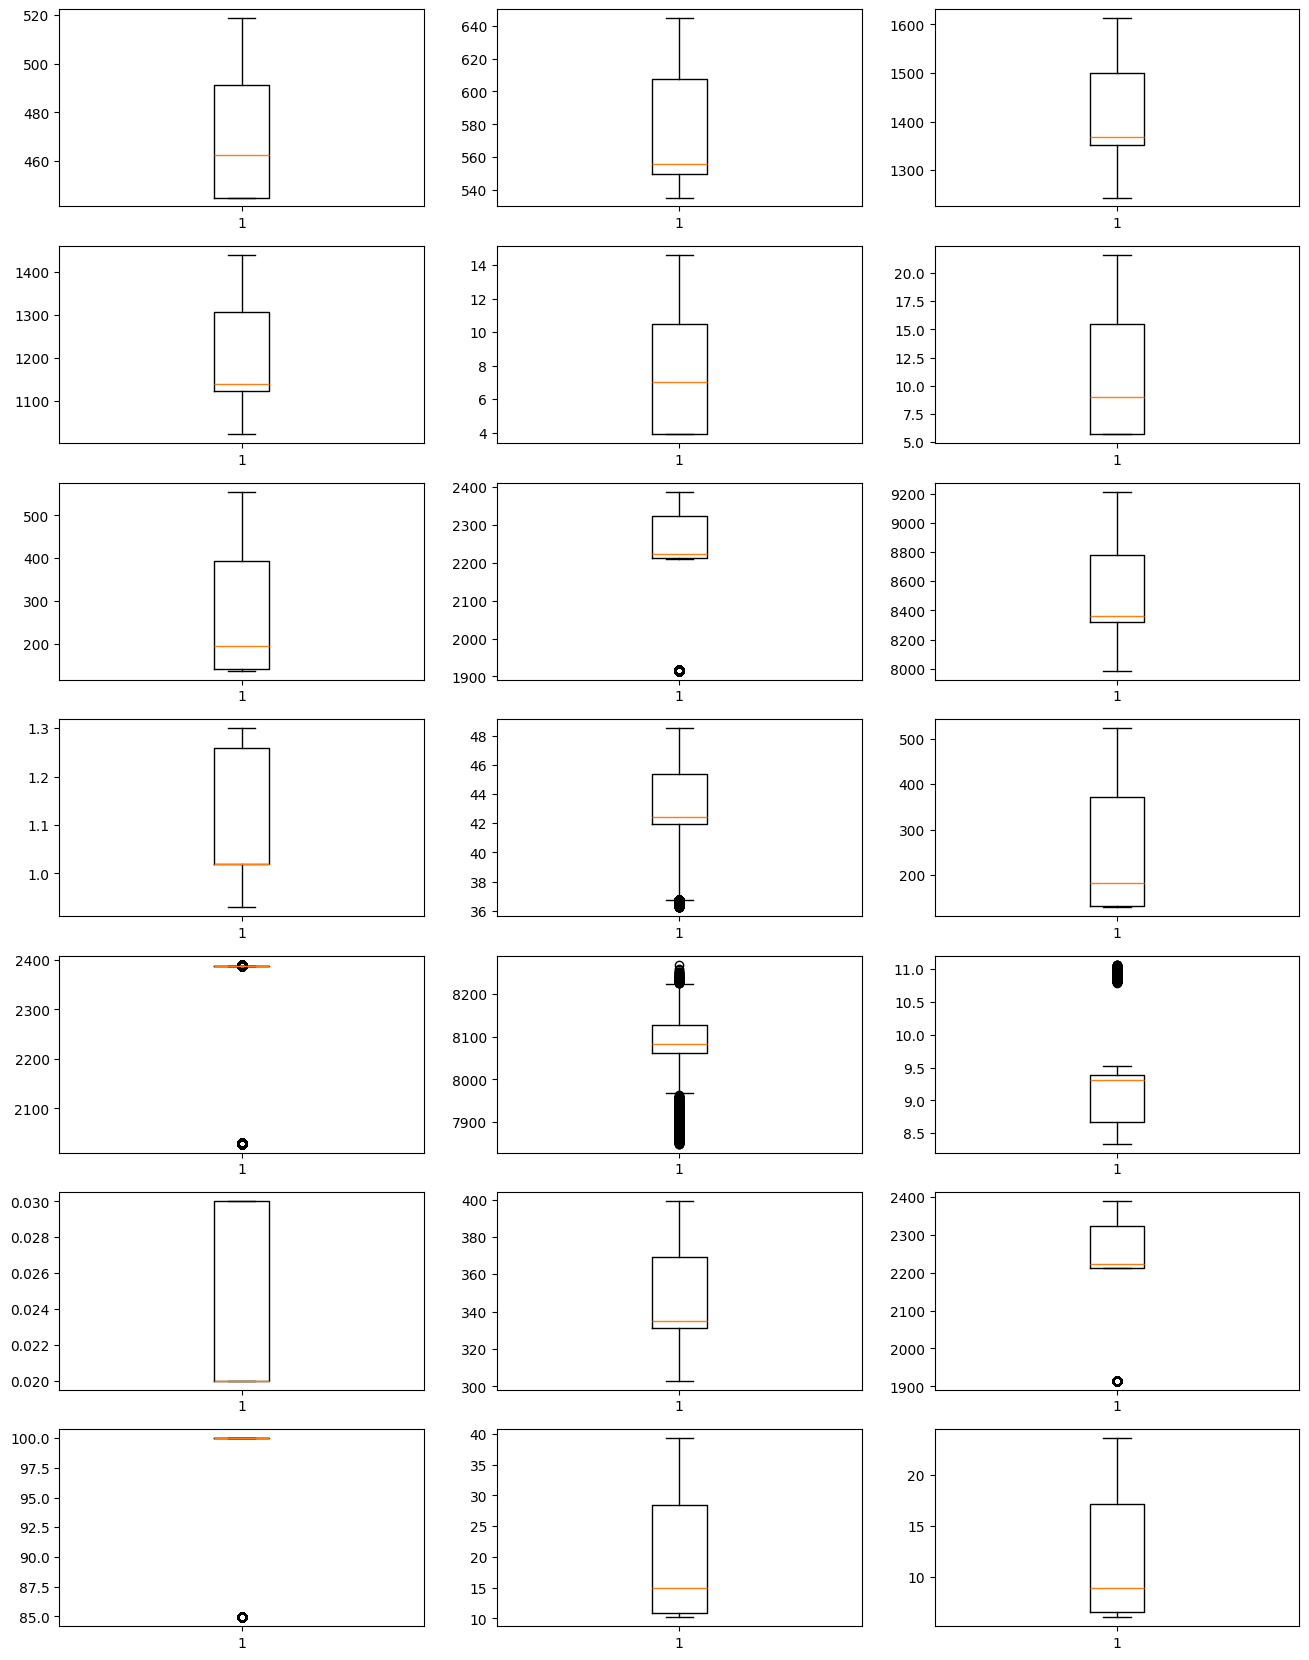

In [2]:
train_data = pd.read_csv("../../CMAPSS/train_FD002.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [3]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
        
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets
    
    

In [4]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]                                                
    
    else:
        max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
        
        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask
        
        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

In [5]:
test_data = pd.read_csv("../../CMAPSS/test_FD002.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD002.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 150         
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []
test_mask = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

#Scale data for all engines
#scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine = process_test_data(temp_test_data,
                                                                                      window_length = window_length,
                                                                                      shift = shift,
                                                                                      num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (46219, 30, 14)
Processed training ruls shape:  (46219,)
Processed test data shape:  (1267, 30, 14)
Test mask shape:  (1267, 30)
True RUL shape:  (259,)


In [6]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 38)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (36975, 30, 14)
Processed validation data shape:  (9244, 30, 14)
Processed train targets shape:  (36975,)
Processed validation targets shape:  (9244,)


In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask)).batch(128).prefetch(tf.data.AUTOTUNE)

In [7]:
def custom_loss(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [8]:
from keras.layers import LSTM, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers 
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss)
    return model

In [12]:
lstm_small_quad = createLSTMsmallModel(60, 30, 30, 15, (30, 14))

In [13]:

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20 :
        return 0.001
    elif epoch >= 20 and epoch < 30: 
        return 0.0001
    elif epoch >= 30: 
        return 0.00001
    else: 
        return 0.01; 

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [14]:
EPOCHS = 50 #50
BATCH_SIZE = 256 #256

history = lstm_small_quad.fit(processed_train_data, processed_train_targets, epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets),
                     callbacks= callback,
                     batch_size=BATCH_SIZE)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2024-01-03 00:12:48.438402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-03 00:12:49.440114: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f288014c650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 00:12:49.440204: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-01-03 00:12:49.449984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-03 00:12:49.564772: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 [==============================] - 7s 15ms/step - loss: 2097.6633 - val_loss: 1749.8257 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 1415.9978 - val_loss: 725.8528 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
145/145 [==============================] - 1s 10ms/step - loss: 682.6885 - val_loss: 624.9579 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 633.6114 - val_loss: 597.1087 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
145/145 [==============================] - 1s 10ms/step - loss: 592.7239 - val_loss: 642.6720 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/50
145/145 [

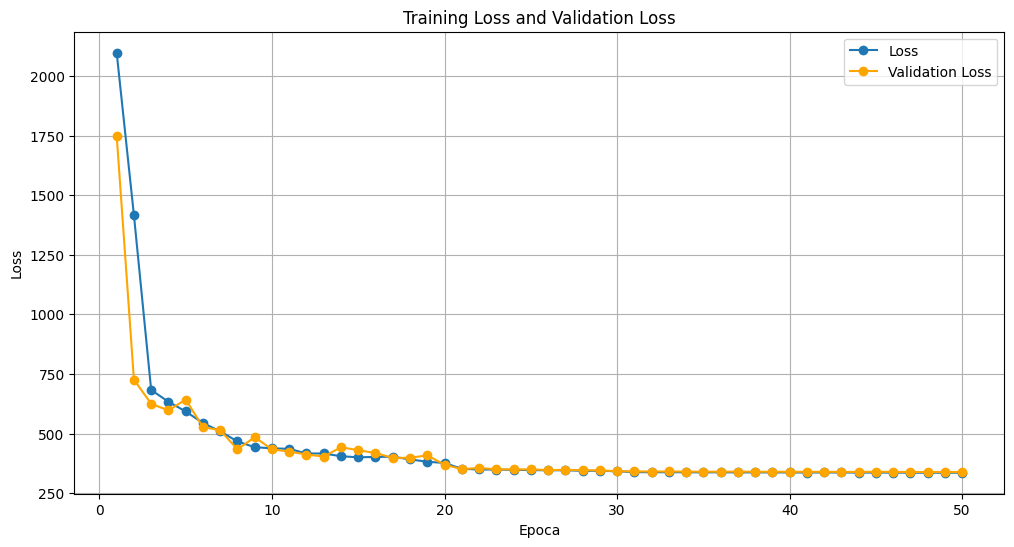

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss) + 1), loss, label='Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
#plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
rul_pred_scaled = []
for test_data, test_mask in test_dataset:
    batch_pred = lstm_small_quad(test_data, mask = test_mask)
    rul_pred_scaled.extend(batch_pred.numpy().reshape(-1))

rul_pred_scaled = np.array(rul_pred_scaled) # initially rul_pred_scaled was just a list. So converted it to numpy array.
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [16]:
rul_pred = lstm_small_quad.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

40/40 [==============================] - 1s 5ms/step
RMSE:  31.94877416372505
